In [23]:
import numpy as np

In [24]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []# 接受输入接受输出
        
        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes outbound_nodes
            
        self.value = None
        
        self.gradients = {
            # if is wx+b, this will be 
            # w: x 对w求偏导是x
            # x: w 对x求偏导是w
            # b: 1 对b求偏导是1
        }
        """keys are the inputs to this node;
        their values are the partials of this node with respect to that input 
        \partial{node}{input_i} key是节点的输入，key对应的value是该节点对应于输入的部分"""
        
    def forward(self):
        """
        forward propagation
        compute the output value on 'inbound_nodes' and store the result in self.value
        前向传播
        计算输入节点的输出值并在self.value上存储结果
        """
        raise NotImplemented
    
    def backward(self):
        raise NotImplemented

In [25]:
class Input(Node):
    def __init__(self):
        '''
        an input node has no inbound nodes
        so no need to pass anything to the node instantiator(实例化？)
        没有输入节点的输入节点  tf.Variable

        '''
        Node.__init__(self)
        
    def forward(self, value=None):

#         Only input node is the node where the value may be passed as an argument to forward().
#         All other node implementations should get the value of the previous node from self.inbound_nodes
        
#         Example: 
#         val0: self.inbound_nodes[0].value

        if value is not None:
            self.value = value # 也可等于2* value等等不一样的计算方式
            # 这是输入节点，当需要前向传播时，这个节点初始化自己的值
         # 输入仅有值的子类，例如数据特征或者一个模型参数（权重、偏置项）
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1 
            
         # 输入N --> N1, N2 
         # \partial L / \partial N 
         # ==> \partial L / \partial N1 * \ partial N1 / \partial N

In [26]:
class Add(Node):
    
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        # 执行Forward时，此节点根据定义计算值
    

In [27]:
class Linear(Node):
    
    def  __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        
        # 为每一个出入节点初始化一个partial(偏置)偏导数
        # initial a partial for each of the inbound_nodes
        # np.zeros_like(n.value)为每个n.value生成一个同类型同样子的元素都是0的矩阵
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            # get the partial of the cost w.r.t this node
            grad_cost = n.gradients[self] # 偏f/self
            
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            # 后面value.T 是因为考虑到numpy中数组的形状，对x求偏导
            
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            # 对w求偏导 偏f/偏linear * 偏linear/偏w
            
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            # 对b求偏导  偏f/偏linear * 偏linear/偏w=偏f/偏linear * 1=grad_cost
            # np.sum默认axis为None，表示将所有元素的值相加.对于二维数组,axis=1表示按行相加
            # , axis=0表示按列相加


In [28]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^ -x)
        # y' = y(1 - y)
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            # get the partial of the cost with respect to this node
            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to 保持所有的维度一样

In [29]:
class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0] # 表示y的元素个数
        self.diff = y - a
        
        self.value = np.mean(self.diff ** 2)
        # np.mean 求均值  axis=0、1，计算每一列、行的均值  1/m（y-a）^ 2
        
    def backward(self):
        # 以下两个分别是对y求偏导，对a也就是yhat求偏导
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        

In [30]:
def forward_and_backward(outputnode, graph):
    
    # 运行排序节点的所有forward方法
    # 实际应用中，经常有大量的数据而不是1个通过forward方法。因为样本可以并行处理。
    # batch_size表示依次进入forward函数的样本的数量
    # session.run()的过程
    
    for n in graph:
        n.forward()
        # 每个节点运行forward方法，依据拓扑排序的结果获得self.value
    
    for n in graph[::-1]:
        n.backward()
        
    # 返回 outputnode.value
    
###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

In [31]:
def topological_sort(feed_dict):
    """使用Kahn算法按拓扑顺序对一般节点排序。
    ` feed_dict`：一种字典，其中key是“input”节点，value是向该节点提供的相应的值。
     返回已排序节点的列表。 """
    
    input_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            # 如果n是输入节点，把n的value设置为feed_dict[n]
            # 否则，n的value通过他的输入来计算
            
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # 如果没有其他 引入的边添加到S
            if len(G[m]['in']) == 0:
                S.add(m)
                
    return L

def sgd_update(trainables, learning_rate=1e-2):
    # 有很多种更新、最优化方法，例如Adam，Mom
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]
            

In [32]:
from sklearn.datasets import load_boston

In [33]:
data = load_boston()

In [34]:
losses = []

In [35]:
"""
选择新的网络架构和数据集。注意到权重和偏置是随机生成的。
不需要改变任何事情，但可以随意调整来测试您的网络，play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

# load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0) # std是标准差 mean是求均值

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden,1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000

# 样本总数
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print('total number of examples = {}'.format(m))

# step4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # step1 随机抽取一批样本 randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size) 
        # resample重新取样 参数n_sample是生成样本的数量
        
        # Reset value of X and y Inputs 重置x和y的输入值
        X.value = X_batch
        y.value = y_batch
        
        # step2
        _ = None
        forward_and_backward(_, graph) # 设置不重要的输出节点
        
        #step3
        rate = 1e-2
        
        sgd_update(trainables,rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)
        
        




total number of examples = 506
Epoch: 1, Loss: 210.963
Epoch: 101, Loss: 7.718
Epoch: 201, Loss: 5.483
Epoch: 301, Loss: 5.498
Epoch: 401, Loss: 5.026
Epoch: 501, Loss: 4.389
Epoch: 601, Loss: 4.430
Epoch: 701, Loss: 3.836
Epoch: 801, Loss: 4.008
Epoch: 901, Loss: 4.243
Epoch: 1001, Loss: 5.371
Epoch: 1101, Loss: 4.753
Epoch: 1201, Loss: 4.063
Epoch: 1301, Loss: 4.862
Epoch: 1401, Loss: 4.706
Epoch: 1501, Loss: 4.576
Epoch: 1601, Loss: 4.016
Epoch: 1701, Loss: 4.134
Epoch: 1801, Loss: 4.008
Epoch: 1901, Loss: 3.870
Epoch: 2001, Loss: 4.133
Epoch: 2101, Loss: 4.117
Epoch: 2201, Loss: 4.144
Epoch: 2301, Loss: 4.321
Epoch: 2401, Loss: 3.377
Epoch: 2501, Loss: 3.670
Epoch: 2601, Loss: 3.491
Epoch: 2701, Loss: 3.775
Epoch: 2801, Loss: 3.997
Epoch: 2901, Loss: 4.007
Epoch: 3001, Loss: 3.506
Epoch: 3101, Loss: 3.716
Epoch: 3201, Loss: 3.308
Epoch: 3301, Loss: 3.644
Epoch: 3401, Loss: 4.513
Epoch: 3501, Loss: 3.339
Epoch: 3601, Loss: 3.527
Epoch: 3701, Loss: 4.058
Epoch: 3801, Loss: 3.645
Epoc

In [36]:
import matplotlib.pyplot as plt

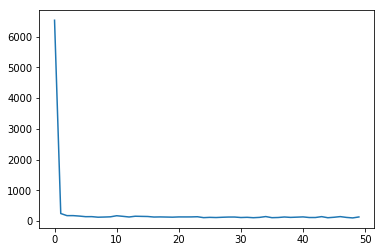

In [37]:
plt.plot(range(len(losses)), losses)

In [38]:
W2.value

array([[ 5.3198084 ],
       [ 5.07402485],
       [10.4281115 ],
       [ 5.97012463],
       [ 5.23506546],
       [ 9.22472738],
       [ 8.56420795],
       [ 4.3360556 ],
       [ 5.76495039],
       [ 4.90587072]])

In [39]:
X_ = data['data']

In [40]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [41]:
import keras

ModuleNotFoundError: No module named 'keras'